In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.io import wavfile

# Classification Model
16kHz 신호 1초분량에 대해 잡음이 있는지 없는지 판별

In [2]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels= 4, kernel_size = 32, stride = 2, padding=15),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Conv1d(in_channels=4,out_channels= 8, kernel_size = 32, stride = 2, padding=15),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Conv1d(in_channels=8,out_channels= 16, kernel_size = 32, stride = 2, padding=15),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32768 , 1000),
            nn.ReLU(),
            nn.Linear(1000, 2)
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            elif isinstance(m, nn.Linear):

                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(x.size()[0], -1)
        #print(out.shape)
        out = self.fc_layer(out)
        
        return out

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
cnn = CNN_1D().to(device)

<ipython-input-2-e02e9294607c>:26: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-2-e02e9294607c>:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


# Load Data
Noise suprresion에 사용했던 데이터 사용 <br>
[1, 0]: clean speech<br>
[0, 1]: Noisy speech<br>

In [5]:
# Load clean data
clean_data = torch.load('./NoiseCancelation/data/clean_test.pt')

# Load noisy data
noise_data = torch.load('./NoiseCancelation/data/noisy_test.pt')

# Make Classification Label
label = []
for i in range(clean_data.shape[0]):
    label.append([0])

for i in range(noise_data.shape[0]):
    label.append([1])

# Change Label to Tensor
train_target = torch.Tensor(label)
    
# Change dimension of data
train_data = torch.cat([clean_data,noise_data], dim=0)

# Data + Label
train_data = torch.cat([train_data, train_target], dim=1)

train_data = torch.unsqueeze(train_data, 1)

print(train_data.shape)

torch.Size([7258, 1, 16385])


# Train

In [194]:
lr = 0.0002
batchsize =30
epochs = 100

In [195]:
cnn_optimizer = optim.Adam(cnn.parameters(), lr = lr)
loss_func = nn.CrossEntropyLoss()

In [196]:
data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=batchsize,
                                          shuffle=True)
#for data in data_loader:
#    print("Data: ", data)
#    print(data.shape)
#    print("Label: ", data[:,:,16384:])
#    break

In [9]:
for ep in range(epochs):
    loss_sum = 0
    amount = 0
    for data in data_loader:
        X = data[:,:,:16384].to(device)
        Y = torch.squeeze(data[:,:,16384:]).long().to(device)
        
        cnn_optimizer.zero_grad()
        output = cnn.forward(X)
        loss = loss_func(output, Y)
        loss.backward()
        cnn_optimizer.step()
        
        loss_sum += loss.cpu().data.numpy()
        amount += batchsize
    if ep % 10 == 0:
        print(ep, amount, loss_sum/amount)

0 7260 0.02387935973231786
10 7260 0.004812055924194082
20 7260 0.0021040777048511694
30 7260 0.0013216402253056504
40 7260 0.0007962686885375585
50 7260 0.0004523663309520482
60 7260 0.0004815851689590874
70 7260 0.0002556728433905508
80 7260 0.0006211744722473372
90 7260 0.00023646560806839598


# 모델 저장 및 평가

In [10]:
#torch.save(cnn.state_dict(), "./cnn_model.pt")

In [6]:
cnn = CNN_1D()
cnn.load_state_dict(torch.load('./cnn_model.pt'))
cnn.eval()

<ipython-input-2-e02e9294607c>:26: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-2-e02e9294607c>:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


CNN_1D(
  (conv_layer): Sequential(
    (0): Conv1d(1, 4, kernel_size=(32,), stride=(2,), padding=(15,))
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(4, 8, kernel_size=(32,), stride=(2,), padding=(15,))
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(8, 16, kernel_size=(32,), stride=(2,), padding=(15,))
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=32768, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=2, bias=True)
  )
)

In [7]:
with torch.no_grad():
    predict = cnn.forward(train_data[:,:,:16384]).cpu().data.numpy()

In [8]:
count = 0
for i in range(len(predict)):
    if int(np.squeeze(train_data[i,:,16384:].numpy()[0])) == np.argmax(predict[i]):
        count+=1
        
print("Acc: {:.3f}".format(count/len(predict)*100))

Acc: 99.904


# Grad-CAM
모델이 중요하게 생각하는 신호 부분 확인 <br>
reference: https://github.com/GunhoChoi/Grad-CAM-Pytorch/blob/master/GradCAM_MNIST.ipynb

In [72]:
class GuidedBackpropRelu(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
     
guided_relu = GuidedBackpropRelu.apply

In [220]:
class GuidedReluModel(nn.Module):
    def __init__(self,model,to_be_replaced,replace_to):
        super(GuidedReluModel,self).__init__()
        self.model = model
        self.to_be_replaced = to_be_replaced
        self.replace_to = replace_to
        self.layers=[]
        self.output=[]
        
        for m in self.model.modules():
            if isinstance(m,self.to_be_replaced):
                self.layers.append(self.replace_to )
                #self.layers.append(m)
            elif isinstance(m,nn.Conv1d):
                self.layers.append(m)
            elif isinstance(m,nn.BatchNorm1d):
                self.layers.append(m)
            elif isinstance(m,nn.Linear):
                self.layers.append(m)
            elif isinstance(m,nn.AvgPool1d):
                self.layers.append(m)
                
        for i in self.layers:
            print(i)
        
        
    def reset_output(self):
        self.output = []
    
    def hook(self,grad):
        #print(grad.shape)
        out = grad[:,0,:].cpu().data#.numpy()
        #print("out_size:",out.size())
        self.output.append(out)
        
    def get_visual(self,idx,original_img):
        grad = self.output[0][idx]
        return grad
        
    def forward(self,x):
        out = x 
        out.register_hook(self.hook)
        for i in self.layers[:-3]:
            out = i(out)
        out = out.view(out.size()[0],-1)
        for j in self.layers[-3:]:
            out = j(out)
        return out
    
guide = GuidedReluModel(model,nn.ReLU,guided_relu)

Conv1d(1, 4, kernel_size=(32,), stride=(2,), padding=(15,))
BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x000001AFBB1867A0>
Conv1d(4, 8, kernel_size=(32,), stride=(2,), padding=(15,))
BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x000001AFBB1867A0>
Conv1d(8, 16, kernel_size=(32,), stride=(2,), padding=(15,))
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<built-in method apply of FunctionMeta object at 0x000001AFBB1867A0>
Linear(in_features=32768, out_features=1000, bias=True)
<built-in method apply of FunctionMeta object at 0x000001AFBB1867A0>
Linear(in_features=1000, out_features=2, bias=True)


# Visualization

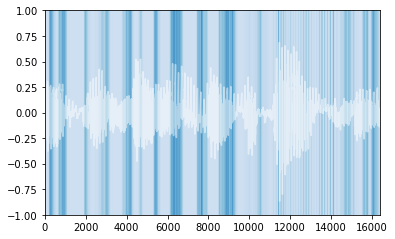

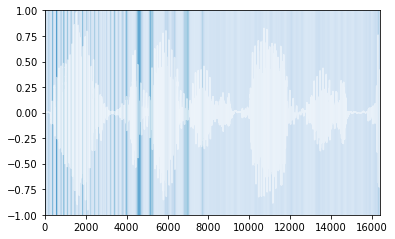

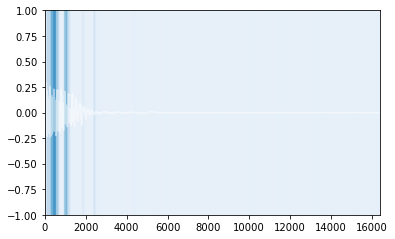

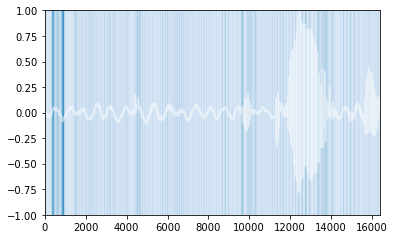

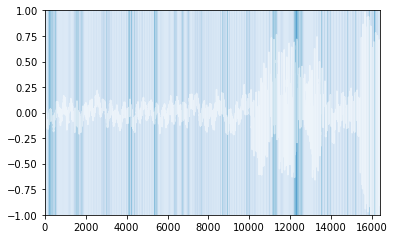

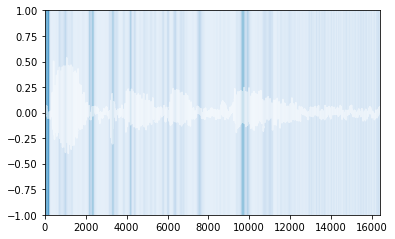

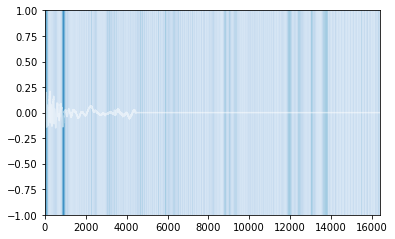

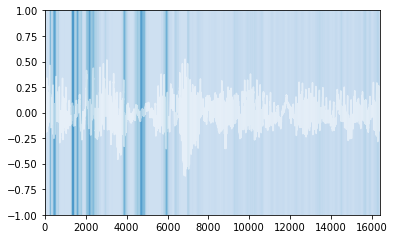

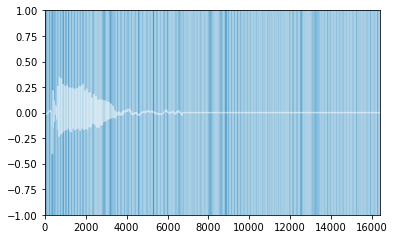

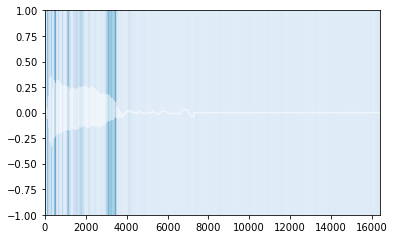

In [226]:
for j, data in enumerate(data_loader):
        X = Variable(data[:,:,:16384].to(device),requires_grad=True)
        Y = Variable(torch.squeeze(data[:,:,16384:]).long().to(device))
        
        output = guide.forward(X) 
        output = torch.index_select(output,dim=1,index=Y)
        output = torch.sum(output)
        output.backward(retain_graph=True)
        
        
        for j in range(10):
            guided_img = guide.get_visual(j, X)
            guided_img = np.expand_dims(guided_img, 0)
            
            plt.plot(np.squeeze(X.cpu().detach().numpy())[j], c='w', alpha = 0.5)
            plt.imshow(guided_img, aspect = 5000, cmap="Blues", extent = [0,16384,-1,1])
            plt.ylim(-1, 1)
            plt.show()
        
        break